# Softmax 回归的从零开始实现

下面我们来动手实现 Softmax 回归。首先，导入实验所需的包或模块。

In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, nd
from mxnet.gluon import data as gdata

## 获取 Fashion-MNIST 数据集

本节中，我们考虑图片分类问题。我们使用一个类别为服饰的数据集 Fashion-MNIST [1]。该数据集中，图片的高和宽均为 28 像素，一共包括了 10 个类别，分别为：t-shirt（T 恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和 ankle boot（短靴）。训练数据集中和测试数据集中的每个类别的图片数分别为 6,000 和 1,000。

下面，我们通过 Gluon 的 `data` 包来下载这个数据集。

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

我们可以通过 `[]` 来访问任意一个样本，下面获取第一个样本和图片和标签。

In [3]:
feature, label = mnist_train[0]

图片的高和宽均为 28 像素。每个像素的数值为 0 到 255 之间 8 位无符号整数（uint8）。它使用 3 维的 NDArray 储存。其中的最后一维是通道数：1 表示灰度图片。

In [4]:
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

下面定义一个可以在一行里画出多张图片的函数。

In [5]:
def show_fashion_imgs(images):
    _, figs = gb.plt.subplots(1, len(images), figsize=(15, 15))
    for f, img in zip(figs, images):
        f.imshow(img.reshape((28, 28)).asnumpy())
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    gb.plt.show()

图片的标签使用 numpy 的标量表示。它的类型为 32 位整数。

In [6]:
label, type(label), label.dtype

(2, numpy.int32, dtype('int32'))

以下函数可以将数值标签转成相应的文本标签。

In [7]:
def get_text_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

现在，我们看一下训练数据集中前 9 个样本的图片内容和文本标签。

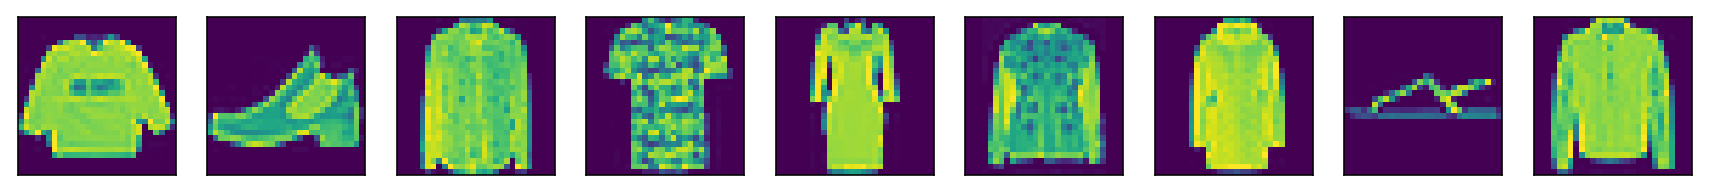

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress', 'coat', 'coat', 'sandal', 'coat']


In [8]:
X, y = mnist_train[0:9]
show_fashion_imgs(X)
print(get_text_labels(y))

## 读取数据

Fashion-MNIST 包括训练数据集和测试数据集（testing data set）。我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。对于训练数据集，我们需要使用随机顺序访问其样本。

我们可以像 [“线性回归的从零开始实现”](linear-regression-scratch.md) 一节中那样通过 `yield` 来定义读取小批量数据样本的函数。为了代码简洁，这里我们直接创建 DataLoader 实例，其每次读取一个样本数为 `batch_size` 的小批量。这里的批量大小 `batch_size` 是一个超参数。在实际中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。Gluon 的 `DataLoader` 中一个很方便的功能是允许使用多进程来加速数据读取。这里我们通过参数 `num_workers` 来设置 4 个进程读取数据。

此外，我们通过 `ToTensor` 将图片数据从 uint8 格式变换成 32 位浮点数格式，并除以 255 使得所有像素的数值均在 0 到 1 之间。`ToTensor` 还将图片通道从最后一维调整到最前一维来方便之后介绍的卷积神经网络使用。通过数据集的 `transform_first` 函数，我们将 `ToTensor` 的变换应用在每个数据样本（图片和标签）的第一个元素，也即图片之上。

In [9]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
                              batch_size, shuffle=True, num_workers=4)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer), 
                             batch_size, shuffle=False, num_workers=4)

我们将获取并读取 Fashion-MNIST 数据集的逻辑封装在 `gluonbook.load_data_fashion_mnist` 函数中供后面章节调用。随着本书内容的不断深入，我们会进一步改进该函数。它的完整实现将在 [“深度卷积神经网络（AlexNet）”](../chapter_convolutional-neural-networks/alexnet.md) 一节中描述。


## 初始化模型参数

跟线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本是高和宽均为 28 像素的图片。模型的输入向量的长度是 $28 \times 28 = 784$：该向量的每个元素对应图片中每个像素。由于图片有 10 个类别，单层神经网络输出层的输出个数为 10。由上一节可知，Softmax 回归的权重和偏差参数分别为 $784 \times 10$ 和 $1 \times 10$ 的矩阵。

In [10]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)
params = [W, b]

同之前一样，我们要对模型参数附上梯度。

In [11]:
for param in params:
    param.attach_grad()

## 定义 Softmax 运算

在介绍如何定义 Softmax 回归之前，我们先描述一下对如何对多维 NDArray 按维度操作。在下面例子中，给定一个 NDArray 矩阵 `X`。我们可以只对其中每一列（`axis=0`）或每一行（`axis=1`）求和，并在结果中保留行和列这两个维度（`keepdims=True`）。

In [12]:
X = nd.array([[1,2,3], [4,5,6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[ 5.  7.  9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[  6.]
  [ 15.]]
 <NDArray 2x1 @cpu(0)>)

下面我们就可以定义上一节中介绍的 Softmax 运算了。在下面的函数中，矩阵 `X` 的行数是样本数，列数是输出个数。为了表达样本预测各个输出的概率，Softmax 运算会先通过 `exp = nd.exp(X)` 对每个元素做指数运算，再对 `exp` 矩阵的每行求和，最后令矩阵每行各元素与该行元素之和相除。这样一来，最终得到的矩阵每行元素和为 1 且非负（应用了指数运算）。因此，该矩阵每行都是合法的概率分布。Softmax 运算的输出矩阵中的任意一行元素是一个样本在各个类别上的概率。

In [13]:
def softmax(X):
    exp = X.exp()
    partition = exp.sum(axis=1, keepdims=True)
    return exp / partition # 这里应用了广播机制。

可以看到，对于随机输入，我们将每个元素变成了非负数，而且每一行加起来为 1。

In [14]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[ 0.21324193  0.33961776  0.1239742   0.27106097  0.05210521]
  [ 0.11462264  0.3461234   0.19401033  0.29583326  0.04941036]]
 <NDArray 2x5 @cpu(0)>, 
 [ 1.00000012  1.        ]
 <NDArray 2 @cpu(0)>)

## 定义模型

有了 Softmax 运算，我们可以定义上节描述的 Softmax 回归模型了。这里通过 `reshape` 函数将每张原始图片改成长度为 `num_inputs` 的向量。

In [15]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## 定义损失函数

上一节中，我们介绍了 Softmax 回归使用的交叉熵损失函数。为了得到标签的被预测概率，我们可以使用 `pick` 函数。在下面例子中，`y_hat` 是 2 个样本在 3 个类别的预测概率，`y` 是两个样本的标签类别。通过使用 `pick` 函数，我们得到了 2 个样本的标签的被预测概率。

In [16]:
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2])
nd.pick(y_hat, y)


[ 0.1  0.5]
<NDArray 2 @cpu(0)>

下面，我们直接将上一节中的交叉熵损失函数翻译成代码。

In [17]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat.log(), y)

## 计算分类准确率

给定一个类别的预测概率分布 `y_hat`，我们把预测概率最大的类别作为输出类别。如果它与真实类别 `y` 一致，说明这次预测是正确的。分类准确率即正确预测数量与总预测数量的比。

下面定义 `accuracy` 函数。其中 `y_hat.argmax(axis=1)` 返回矩阵 `y_hat` 每行中最大元素的索引，且返回结果与 `y` 形状相同。我们在 [“数据操作”](../chapter_prerequisite/ndarray.md) 一节介绍过，条件判断式 `(y_hat.argmax(axis=1) == y)` 是一个值为 0 或 1 的 NDArray。由于标签类型为整数，我们先将其变换为浮点数再进行比较。

In [18]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

让我们继续使用在演示 `pick` 函数时定义的 `y_hat` 和 `y`，分别作为预测概率分布和标签。可以看到，第一个样本预测类别为 2（该行最大元素 0.6 在本行的索引），与真实标签不一致；第二个样本预测类别为 2（该行最大元素 0.5 在本行的索引），与真实标签一致。因此，这两个样本上的分类准确率为 0.5。

In [19]:
accuracy(y_hat, y)

0.5

类似地，我们可以评价模型 `net` 在数据集 `data_iter` 上的准确率。

In [20]:
def evaluate_accuracy(data_iter, net):
    acc = 0
    for X, y in data_iter:
        acc += accuracy(net(X), y)
    return acc / len(data_iter)

因为我们随机初始化了模型 `net`，所以这个模型的准确率应该接近于 `1 / num_outputs = 0.1`。

In [21]:
evaluate_accuracy(test_iter, net)

0.0947265625

## 训练模型

训练 Softmax 回归的实现跟前面线性回归中的实现非常相似。我们同样使用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数 `num_epochs` 和学习率 `lr` 都是可以调的超参数。改变它们的值可能会得到分类更准确的模型。

In [22]:
num_epochs = 5
lr = 0.1
loss = cross_entropy

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(1, num_epochs + 1):
        train_l_sum = 0
        train_acc_sum = 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            if trainer is None:
                gb.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            train_l_sum += l.mean().asscalar()
            train_acc_sum += accuracy(y_hat, y)
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' 
              % (epoch, train_l_sum / len(train_iter),
                 train_acc_sum / len(train_iter), test_acc))

train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params,
          lr)

epoch 1, loss 0.7885, train acc 0.747, test acc 0.799


epoch 2, loss 0.5743, train acc 0.810, test acc 0.826


epoch 3, loss 0.5298, train acc 0.823, test acc 0.832


epoch 4, loss 0.5052, train acc 0.830, test acc 0.838


epoch 5, loss 0.4887, train acc 0.835, test acc 0.838


## 预测

训练完成后，现在我们可以演示如何对图片进行分类。给定一系列图片，我们比较一下它们的真实标签和模型预测结果。

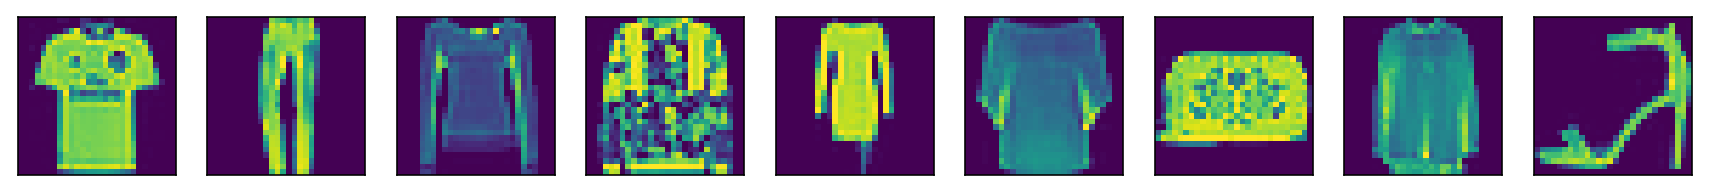

labels: ['t-shirt', 'trouser', 'pullover', 'pullover', 'dress', 'pullover', 'bag', 'shirt', 'sandal']
predictions: ['t-shirt', 'trouser', 'pullover', 'shirt', 'coat', 'shirt', 'bag', 'shirt', 'sandal']


In [23]:
data, label = mnist_test[0:9]
show_fashion_imgs(data)
print('labels:', get_text_labels(label))
    
predicted_labels = [net(transformer(x)).argmax(axis=1).asscalar()
                    for x in data]
print('predictions:', get_text_labels(predicted_labels))

本节中的 `accuracy`、`evaluate_accuracy` 和 `train_ch3` 函数被定义在 `gluonbook` 包中供后面章节调用。其中的 `evaluate_accuracy` 函数将被逐步改进：它的完整实现将在 [“图片增广”](../chapter_computer-vision/image-augmentation.md) 一节中描述。


## 小结

* 与训练线性回归相比，你会发现训练 Softmax 回归的步骤跟其非常相似：获取并读取数据、定义模型和损失函数并使用优化算法训练模型。事实上，绝大多数深度学习模型的训练都有着类似的步骤。

* 我们可以使用 Softmax 回归做多类别分类。

## 练习

* 本节中，我们直接按照 Softmax 运算的数学定义来实现 `softmax` 函数。这可能会造成什么问题？（试一试计算 $e^{50}$ 的大小。）
* 本节中的 `cross_entropy` 函数同样是按照交叉熵损失函数的数学定义实现的。这样的实现方式可能有什么问题？（思考一下对数函数的定义域。）
* 你能想到哪些办法来解决上面这两个问题？
* 修改 `DataLoader` 里的参数 `num_workers`，查看这个改动对计算性能的影响。

## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/741)

![](../img/qr_softmax-regression-scratch.svg)

## 参考文献

[1] Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.